In [1]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt

from IPython.display import clear_output
%matplotlib inline

In [2]:
pd.options.display.max_columns = 999
gr      = 1.618
nan     = -2147483648
min_root_size = 20000 # Skip root files smaller than x bytes

mass_p= 0.93827 #GeV
mass_e= 0.00511 #GeV

# dead wires
z_dead_start = 675
z_dead_end=z_dead_start+100

# Minimum reconstructable energies:
min_e = 0.02+mass_e # 20MeV
min_p = 0.04+mass_p # 40MeV
min_pi = 0.17

vtx_activity_cut = 5

In [3]:
gpvmsdir = '/run/user/1002/gvfs/sftp:host=uboonegpvm02.fnal.gov,user=wvdp'
# Option 1: no checkana, verify validity yourself and use input directory
inputlist = []
inputlist += glob.glob("/home/wouter/Templates/May/bnb_nue_cosmic_0s0t_dev/*.root")
#inputlist += glob.glob("/home/wouter/Templates/May/bnb_nu_cosmic_0s0t_dev/*.root")
filelist  = []
for fname in inputlist:
    if (os.stat(fname).st_size)<min_root_size:
            print("File",fname,"was corrupt. Size:",os.stat(fname).st_size/1000, "kb, skipping to next file.")
    else:
        filelist.append(fname)

In [4]:
print(len(filelist))

280


In [30]:
def true_thresholds_1eNp(row):
    isProton = 0
    isProtonKin = 0
    isPion = False
    if row["true_1eX_signal"]:
        for pdg,E in zip(*row[["nu_daughters_pdg","nu_daughters_E"]]):
            if pdg==2212:
                isProton +=1 
                if (E>min_p):
                   isProtonKin+=1 
                
            if pdg in [-211,211,111] and E>min_pi:
                isPion = True
                
    sig1 = isProton>0 and not isPion
    sig2 = isProtonKin>0 and not isPion
    sig3 = isProton==1 and not isPion
    sig4 = isProtonKin==1 and not isPion
    return sig1,sig2,sig3,sig4


# Formatting
def sciNot(x):
    x=float(x)
    return "{:.1f}".format(x)

def sciNot2(x):
    x=float(x)
    return "{:.2f}".format(x)

# error unweighter
def effErr(teller,noemer):
    return np.sqrt(teller*(1-teller/noemer))/noemer

def cart2sph(x, y, z):
    hxy = np.hypot(x, y)
    #r = np.hypot(hxy, z)
    theta = np.arctan2(hxy,z)
    phi = np.arctan2(x, y)
    return theta, phi#, r

In [34]:
if 1:
    from root_pandas import read_root
    chunks = []
    
    true_proton = []
    sh_proton = []
    tr_proton = []

    for i_f,fname in enumerate(filelist[:]):
        clear_output(wait=True)
        print (i_f)
        dftemp=read_root(fname,"wouterNueCC/pandoratree",columns=["true_1eX_signal","bnbweight", "nu_E","shower_vtxdistance","track_vtxdistance",
                                                                  "true_vz",
                                                                  "matched_showers", "matched_showers_energy", "shower_theta", "shower_phi",
                                                                  "matched_tracks", "matched_tracks_energy", "track_theta", "track_phi",
                                                                  "nu_daughters_pdg","nu_daughters_E", "nu_daughters_px", "nu_daughters_py", "nu_daughters_pz",
                                                                  "nu_pdg",
                                                                  "fiducial","vz","n_tracks","candidate_pdg","numu_passed",
                                                                  'passed','category',"n_showers",
                                                                  "flash_PE_max", "flash_hypo_PE"])
        
        # Fill proton arrays
        for index, row in dftemp.iterrows():
            if row["true_1eX_signal"]==1:
            ## Truth ones
                for pdg,E,px,py,pz in zip(*row[["nu_daughters_pdg","nu_daughters_E", "nu_daughters_px", "nu_daughters_py", "nu_daughters_pz"]]):
                    if pdg==2212 and E>(mass_p+0.04):
                        theta,phi = cart2sph(px, py, pz)
                        true_proton.append([E-mass_p,theta,phi]) 

            ## Reco ones
                if row["category"]==2: # and row["candidate_pdg"]==12  and row["passed"]==1 and row["fiducial"]==1 :
                    ### Showers
                    for pdg,E,theta,phi in zip(*row[["matched_showers", "matched_showers_energy", "shower_theta", "shower_phi"]]):
                        if pdg==2212 and E>(mass_p+0.04):
                            sh_proton.append([E-mass_p,theta,phi]) 
                    ### Track
                    for pdg,E,theta,phi in zip(*row[["matched_tracks", "matched_tracks_energy", "track_theta", "track_phi"]]):
                        if pdg==2212 and E>(mass_p+0.04):
                            tr_proton.append([E-mass_p,theta,phi]) 
                    
        chunks.append(dftemp)

    df = pd.concat(chunks,ignore_index=True,copy=False) 
    
    df["vtx_activity_nr_sh"] = df.apply(lambda x: sum(x["shower_vtxdistance"]<vtx_activity_cut),axis=1)
    df["vtx_activity_nr_tr"] = df.apply(lambda x: sum(x["track_vtxdistance"]<vtx_activity_cut),axis=1)
    df["vtx_activity_nr"] = df["vtx_activity_nr_sh"]+df["vtx_activity_nr_tr"]
    df["reco_z_deadwire"] = ~df['vz'].between(z_dead_start,z_dead_end)
    df["true_z_deadwire"] = ~df['true_vz'].between(z_dead_start,z_dead_end)
    df["sig1"],df["sig2"],df["sig3"],df["sig4"] = zip(*df.apply(true_thresholds_1eNp,axis=1))
    
    
    df.drop(["nu_daughters_pdg","nu_daughters_E","shower_vtxdistance","track_vtxdistance"],inplace=True,axis=1)
    df.to_pickle("df_nue.pckl")
    
    true_proton = np.transpose(np.array(true_proton))
    tr_proton = np.transpose(np.array(tr_proton))
    sh_proton = np.transpose(np.array(sh_proton))

279


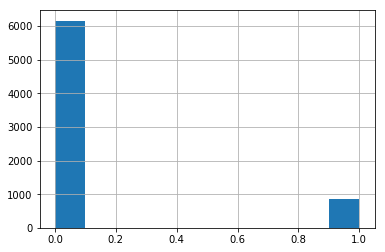

In [33]:
df["sig2"].hist()

51357
5415
19055


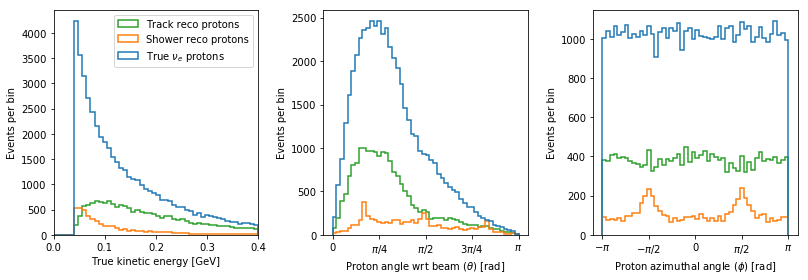

In [50]:
fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(7*gr,4),sharey=False,sharex=False)

xlims = [(0,0.4),(0,np.pi),(-np.pi,np.pi)]
for i,xlim in enumerate(xlims):
    weights = [np.ones_like(true_proton[i])/float(len(true_proton[i])),
               np.ones_like(sh_proton[i])/float(len(sh_proton[i])),
               np.ones_like(tr_proton[i])/float(len(tr_proton[i])),
              ]
    
    ax[i].hist([true_proton[i],sh_proton[i],tr_proton[i]] ,bins=50,alpha=1.0,label=[r"True $\nu_e$ protons","Shower reco protons","Track reco protons"],
               normed=False, histtype='step', stacked=False, lw=1.5, range=xlim)#, weights=weights)

ax[0].set_ylabel(r"Events per bin")
ax[0].set_xlabel("True kinetic energy [GeV]")
ax[0].set_xlim(0,0.4)

ax[1].set_ylabel(r"Events per bin")
x_labels = [r'0', r'${\pi}/{4}$', r'${\pi}/{2}$', r'${3\pi}/{4}$',r'${\pi}$']
x_ticks = [0,np.pi/4,np.pi/2,3*np.pi/4,np.pi]
ax[1].set_xticks(x_ticks)
ax[1].set_xticklabels(x_labels)
ax[0].legend(loc="upper right")
ax[1].set_xlabel(r"Proton angle wrt beam ($\theta$) [rad]")

x_labels = [r'$-{\pi}$',r'$-{\pi}/{2}$',r'0', r'${\pi}/{2}$', r'${\pi}$']
x_ticks = [-np.pi,-np.pi/2,0,np.pi/2,np.pi]
ax[2].set_xticks(x_ticks)
ax[2].set_xticklabels(x_labels)
ax[2].set_ylabel(r"Events per bin")
ax[2].set_xlabel(r"Proton azimuthal angle ($\phi$) [rad]")



fig.tight_layout()
plt.savefig("../../Output/proton_abso.pdf", bbox_inches='tight', pad_inches=0.1)

print(len(true_proton[0]))
print(len(sh_proton[0]))
print(len(tr_proton[0]))

51357
5415
19055


0.22129137719656722

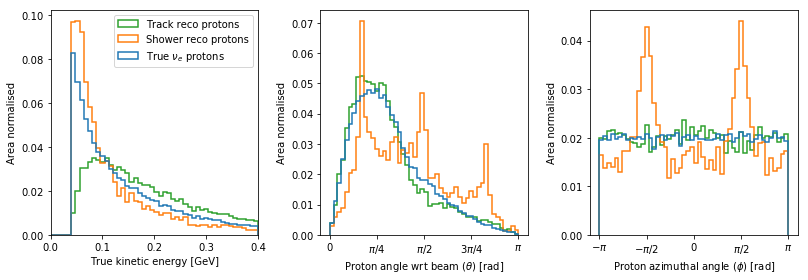

In [57]:
fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(7*gr,4),sharey=False,sharex=False)

xlims = [(0,0.4),(0,np.pi),(-np.pi,np.pi)]
for i,xlim in enumerate(xlims):
    weights = [np.ones_like(true_proton[i])/float(len(true_proton[i])),
               np.ones_like(sh_proton[i])/float(len(sh_proton[i])),
               np.ones_like(tr_proton[i])/float(len(tr_proton[i])),
              ]
    
    ax[i].hist([true_proton[i],sh_proton[i],tr_proton[i]] ,bins=50,alpha=1.0,label=[r"True $\nu_e$ protons","Shower reco protons","Track reco protons"],
               normed=False, histtype='step', stacked=False, lw=1.5, range=xlim, weights=weights)

ax[0].set_ylabel(r"Area normalised")
ax[0].set_xlabel("True kinetic energy [GeV]")
ax[0].set_xlim(0,0.4)

ax[1].set_ylabel(r"Area normalised")
x_labels = [r'0', r'${\pi}/{4}$', r'${\pi}/{2}$', r'${3\pi}/{4}$',r'${\pi}$']
x_ticks = [0,np.pi/4,np.pi/2,3*np.pi/4,np.pi]
ax[1].set_xticks(x_ticks)
ax[1].set_xticklabels(x_labels)
ax[0].legend(loc="upper right")
ax[1].set_xlabel(r"Proton angle wrt beam ($\theta$) [rad]")

x_labels = [r'$-{\pi}$',r'$-{\pi}/{2}$',r'0', r'${\pi}/{2}$', r'${\pi}$']
x_ticks = [-np.pi,-np.pi/2,0,np.pi/2,np.pi]
ax[2].set_xticks(x_ticks)
ax[2].set_xticklabels(x_labels)
ax[2].set_ylabel(r"Area normalised")
ax[2].set_xlabel(r"Proton azimuthal angle ($\phi$) [rad]")



fig.tight_layout()
plt.savefig("../../Output/proton_rela.pdf", bbox_inches='tight', pad_inches=0.1)

print(len(true_proton[0]))
print(len(sh_proton[0]))
print(len(tr_proton[0]))

5415/(19055+5415)

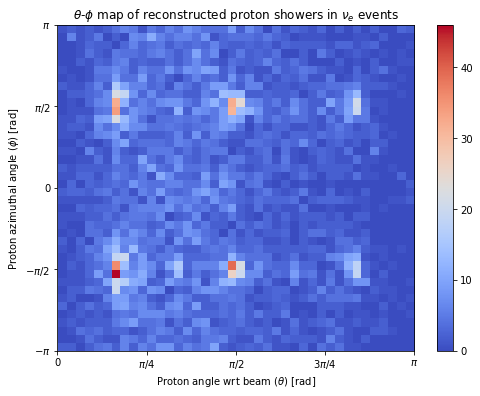

In [52]:
fig,ax=plt.subplots(figsize=(8,6))



hb = ax.hist2d(sh_proton[1], sh_proton[2], bins=40,cmap="coolwarm")
cb = fig.colorbar(hb[3], ax=ax)

x_labels = [r'0', r'${\pi}/{4}$', r'${\pi}/{2}$', r'${3\pi}/{4}$',r'${\pi}$']
x_ticks = [0,np.pi/4,np.pi/2,3*np.pi/4,np.pi]
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels)
ax.set_title(r"$\theta$-$\phi$ map of reconstructed proton showers in $\nu_e$ events")
y_labels = [r'$-{\pi}$',r'$-{\pi}/{2}$',r'0', r'${\pi}/{2}$', r'${\pi}$']
y_ticks = [-np.pi,-np.pi/2,0,np.pi/2,np.pi]
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels)

ax.set_xlabel(r"Proton angle wrt beam ($\theta$) [rad]")
ax.set_ylabel(r"Proton azimuthal angle ($\phi$) [rad]")
plt.savefig("../../Output/theta_phi_map.pdf", bbox_inches='tight')

[ 0.04766667  0.063       0.07833333  0.09366667  0.109       0.12433333
  0.13966667  0.155       0.17033333  0.18566667  0.201       0.21633333
  0.23166667  0.247       0.26233333  0.27766667  0.293       0.30833333
  0.32366667  0.339       0.35433333  0.36966667  0.385       0.40033333
  0.41566667  0.431       0.44633333  0.46166667  0.477       0.49233333]
[ 0.06953291  0.19445419  0.26827094  0.33530201  0.38219732  0.40086674
  0.45238095  0.43691589  0.46940874  0.48630554  0.49193028  0.51365706
  0.53839802  0.53615023  0.53362734  0.53855569  0.58082192  0.53586498
  0.5516129   0.6299639   0.58641975  0.58390805  0.599022    0.6043956
  0.5727003   0.52173913  0.58803987  0.5770751   0.60169492  0.59259259]


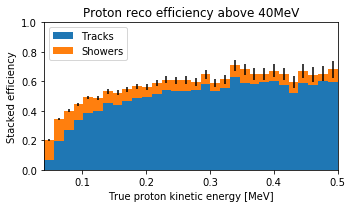

In [56]:
# Proton reco eff
fig,ax=plt.subplots(figsize=(5,3))
x_min = 0.04
x_max = 0.5
N = 30
bhalf=(x_max-x_min)/2/N

true_bins, edges = np.histogram(true_proton[0], bins=N, range = (x_min,x_max))

sh_bins, edges = np.histogram(sh_proton[0], bins=N, range = (x_min,x_max))
tr_bins, edges = np.histogram(tr_proton[0], bins=N, range = (x_min,x_max))

y_err= np.sqrt(sh_bins+tr_bins)/true_bins
ax.bar(edges[:-1]+bhalf,tr_bins/true_bins, label="Tracks",width=2*bhalf)
ax.bar(edges[:-1]+bhalf,sh_bins/true_bins, bottom=tr_bins/true_bins, label="Showers",width=2*bhalf,yerr=y_err)
ax.legend(loc="upper left")
ax.set_xlim(x_min,x_max)
ax.set_ylim(0,1)
ax.set_title("Proton reco efficiency above 40MeV")
ax.set_xlabel("True proton kinetic energy [MeV]")
ax.set_ylabel("Stacked efficiency")


print(edges[:-1]+bhalf)
print(tr_bins/true_bins)


fig.tight_layout()
plt.savefig("../../Output/proton_eff.pdf", bbox_inches='tight')

In [35]:
#df_tune3 = pd.read_pickle("df_nue_tune3.pckl")
df_tune1 = pd.read_pickle("df_nue.pckl")
#print(len(df_tune3.index))
print(len(df_tune1.index))

196000


In [36]:
df_tune1["nu_pdg"].value_counts()

12            190274
4294967284      5726
Name: nu_pdg, dtype: int64

In [40]:
print(sum(df_tune1["true_1eX_signal"]))
print(sum(df_tune1["sig1"]))
print(sum(df_tune1["sig2"]))
print(sum(df_tune1["sig3"]))
print(sum(df_tune1["sig4"]))

print(sum(df_tune1["sig3"])/sum(df_tune1["sig1"])*100)
print(sum(df_tune1["sig4"])/sum(df_tune1["sig2"])*100)

46289
31312
23658
14474
15513
46.2250894226
65.5718995689


In [46]:
str_query = "true_1eX_signal==1 & true_z_deadwire==1"
df_1eX = df_tune1.query(str_query)
df_1eX_tune1 = df_tune1.query(str_query)
df_1eX.head()

df_1eX_tune1["nu_pdg"].value_counts()

12            41583
4294967284        1
Name: nu_pdg, dtype: int64

In [47]:
df_1eNp = df_1eX.query("sig1==1")
df_1eNp40 = df_1eX.query("sig2==1")
df_1e1p = df_1eX.query("sig3==1")
df_1e1p40 = df_1eX.query("sig4==1")
#df_1e1p_tune3 = df_1eX_tune1.query("true_1e1p_signal==1")
#print(len(df_1e1p_tune3))
print(len(df_1e1p))

12980


In [48]:
str_passed = "passed==1 & fiducial==1 & reco_z_deadwire==1 & category==2"
df_passed = df_1eX.query(str_passed)
df_passed_shower = df_passed.query("vtx_activity_nr_sh>0")
df_passed_pdg = df_passed.query("candidate_pdg==12")

df_passed_2obj = df_passed_shower.query("vtx_activity_nr>1")
df_passed_pdg_2obj = df_passed_2obj.query("candidate_pdg==12")
df_passed_shtr = df_passed_shower.query("n_tracks>0")
nominators = [df_passed,df_passed_pdg,df_passed_2obj]
labels = ["Optical + fiducial cuts           ",
          "At least one shower               ",
          "1+shower and other objects "]

In [15]:
nominators[0].head()

,matched_showers_energy,passed,true_1eX_signal,bnbweight,true_vz,nu_pdg,nu_daughters_px,n_showers,matched_showers,nu_daughters_py,n_tracks,fiducial,vz,nu_daughters_pz,nu_E,numu_passed,matched_tracks,matched_tracks_energy,track_phi,category,track_theta,flash_PE_max,flash_hypo_PE,shower_theta,shower_phi,candidate_pdg,vtx_activity_nr_sh,vtx_activity_nr_tr,vtx_activity_nr,reco_z_deadwire,true_z_deadwire,true_1e1p_signal
6,[-1.79769313486e+308],1,1,0.976638,70.391029,12,"[0.374208714359, 0.0, -0.29593701714]",1,[11],"[-0.0360214874636, 0.0, -0.170756143821]",2,1,74.381638,"[0.51494193767, 0.0, 0.0506789742137]",0.760407,0,"[11, 2212]","[0.637569737168, 0.999829539258]","[-0.0906409879937, -2.67236754192]",2,"[0.624400974965, 1.62805570273]",380.012621,"[507.0, 393.0]",[0.62820299478],[-0.0506338198446],14,0,2,2,True,True,True
11,[],1,1,0.537343,390.533393,12,"[0.131336990398, -0.144289941176]",0,[],"[-0.125950167132, 0.142754372998]",2,1,390.517944,"[-0.0920718648939, 0.590430270043]",0.430958,0,"[11, 2212]","[0.203937095871, 1.12701405151]","[-0.722451912717, 2.30455455385]",2,"[2.03432514046, 0.349367381935]",2213.321607,[1594.0],[],[],14,0,2,2,True,True,True
31,[1.27814488774],1,1,0.955723,193.336067,12,"[-0.10076764847, 0.0437767018274, 0.0927817761...",1,[11],"[0.0853422037978, 0.0612219407706, -0.08088264...",1,1,193.532211,"[1.27130510981, 0.256909888298, 0.263374579184...",1.667308,1,[211],[0.281598611067],[-2.53575819473],2,[2.35161873453],11642.854374,[13370.0],[0.138721597739],[2.76499412265],12,1,1,2,True,True,False
54,"[0.605341188701, 0.212077949755]",1,1,0.533945,929.688126,12,"[-0.179452763678, -0.0461324499657, 0.03327814...",2,"[11, 211]","[0.0589675779623, 0.00932116414703, 0.00035093...",0,1,929.289307,"[0.575114965877, -0.0182339843573, -0.01095195...",0.890873,0,[],[],[],2,[],5892.056042,[7343.0],"[0.0964471309355, 1.61400562682]","[0.910162244728, -1.87409012853]",12,2,0,2,True,True,False
91,[],1,1,0.537343,117.387681,12,"[-0.17825415003, 0.257184897156]",0,[],"[0.0952690532132, -0.0950301884571]",1,1,117.745445,"[0.0295632820427, 0.571143392508]",0.436954,0,[2212],[1.13213689686],[-0.34333840591],2,[0.473629604842],3936.509381,[3156.0],[],[],14,0,1,1,True,True,True


In [51]:
E_denom = df_1eX["nu_E"]
weight_denom = df_1eX["bnbweight"]

E_nom1 = df_1eNp["nu_E"]
weight_nom1 = df_1eNp["bnbweight"]

E_nom2 = df_1eNp40["nu_E"]
weight_nom2 = df_1eNp40["bnbweight"]

E_nom3 = df_1e1p["nu_E"]
weight_nom3 = df_1e1p["bnbweight"]

E_nom4 = df_1e1p40["nu_E"]
weight_nom4 = df_1e1p40["bnbweight"]

#E_denom_tune3 = df_1eX_tune1["nu_E"]
#weight_denom_tune3 = df_1eX_tune3["bnbweight"]
#E_nom_tune3 = df_1e1p_tune3["nu_E"]
#weight_nom_tune3 = df_1e1p_tune3["bnbweight"]

62 Optical + fiducial cuts           
49 At least one shower               
38 1+shower and other objects 


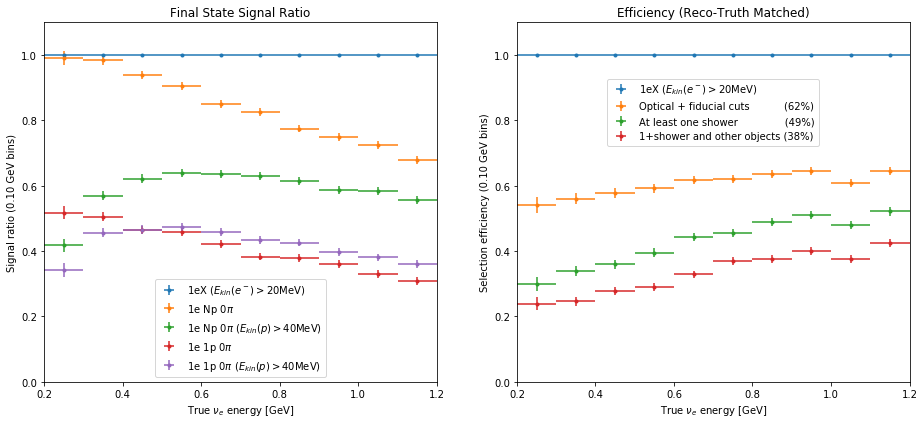

In [58]:
# Make the signal plot to motivate the inclusive channel 
# from a final state point of view and from a reconstruction point of view

fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(8*gr,6),sharey=False,sharex=True)
N = 10
min_x = 0.2
max_x = 1.2
binwidth=(max_x-min_x)/N
halfbin = binwidth/2
step=0.2

denom, edges = np.histogram(E_denom,bins=N,range=(min_x,max_x),weights=weight_denom)
nom1, _       = np.histogram(E_nom1,bins=N,range=(min_x,max_x),weights=weight_nom1)
eff1 = nom1/denom

nom2, _       = np.histogram(E_nom2,bins=N,range=(min_x,max_x),weights=weight_nom2)
eff2 = nom2/denom

nom3, _       = np.histogram(E_nom3,bins=N,range=(min_x,max_x),weights=weight_nom3)
eff3 = nom3/denom

nom4, _       = np.histogram(E_nom4,bins=N,range=(min_x,max_x),weights=weight_nom4)
eff4 = nom4/denom

#denom_tune3, _ = np.histogram(E_denom_tune3,bins=N,range=(min_x,max_x),weights=weight_denom_tune3)
#nom_tune3, _       = np.histogram(E_nom_tune3,bins=N,range=(min_x,max_x),weights=weight_nom_tune3)
#eff_tune3 = nom_tune3/denom_tune3


ax[0].set_title('Final State Signal Ratio')
ax[0].errorbar(edges[:-1]+halfbin, denom/denom , xerr=halfbin, yerr=effErr(denom,denom),alpha=1.0,fmt='.',label=r'1eX ($E_{kin}(e^-) > 20$MeV)')
ax[0].errorbar(edges[:-1]+halfbin, eff1 , xerr=halfbin, yerr=effErr(nom,denom),alpha=1.0,fmt='.',label=r'1e Np 0$\pi$')
ax[0].errorbar(edges[:-1]+halfbin, eff2 , xerr=halfbin, yerr=effErr(nom,denom),alpha=1.0,fmt='.',label=r'1e Np 0$\pi$ ($E_{kin}(p) > 40$MeV)')
ax[0].errorbar(edges[:-1]+halfbin, eff3 , xerr=halfbin, yerr=effErr(nom,denom),alpha=1.0,fmt='.',label=r'1e 1p 0$\pi$')
ax[0].errorbar(edges[:-1]+halfbin, eff4 , xerr=halfbin, yerr=effErr(nom,denom),alpha=1.0,fmt='.',label=r'1e 1p 0$\pi$ ($E_{kin}(p) > 40$MeV)')
#ax[0].errorbar(edges[:-1]+halfbin, eff_tune1 , xerr=halfbin, yerr=effErr(nom_tune1,denom_tune1),alpha=1.0,fmt='.',label=r'1e Np 0$\pi$ ($E_{kin}(p) > 40$MeV) Tune 3')


ax[1].set_title('Efficiency (Reco-Truth Matched)')
ax[1].errorbar(edges[:-1]+halfbin, denom/denom , xerr=halfbin, yerr=effErr(denom,denom),alpha=1.0,fmt='.',label=r'1eX ($E_{kin}(e^-) > 20$MeV)')
for df,lab in zip(nominators,labels):
    percent = int(df[df["bnbweight"]!=1]["bnbweight"].sum()/df_1eX[df_1eX["bnbweight"]!=1]["bnbweight"].sum()*100)
    print(percent,lab)
    nom,_ = np.histogram(df["nu_E"],bins=N,range=(min_x,max_x),weights=df["bnbweight"])
    eff = nom/denom 
    ax[1].errorbar(edges[:-1]+halfbin, eff , xerr=halfbin, yerr=effErr(nom,denom),alpha=1.0,fmt='.',label=lab+"("+str(percent)+"%)")

#ax[0].set_frame_on(False)
#ax[1].set_frame_on(False)

ax[0].set_ylabel('Signal ratio ('+sciNot2(binwidth)+' GeV bins)')
ax[1].set_ylabel('Selection efficiency ('+sciNot2(binwidth)+' GeV bins)')

ax[0].set_xlim(min_x,max_x)
ax[1].set_xlim(min_x,max_x)

ax[0].set_ylim(0,1.1)
ax[1].set_ylim(0,1.1)

ax[0].set_xlabel(r'True $\nu_e$ energy [GeV]')
ax[1].set_xlabel(r'True $\nu_e$ energy [GeV]')

ax[0].legend(loc="lower center")
ax[1].legend(loc="center", bbox_to_anchor=(0.5, 0.75))

plt.tight_layout(w_pad=3.5)
#fig.subplots_adjust(top=0.85)
plt.savefig("../../Output/eff_pur_nue_new.pdf", bbox_inches='tight', pad_inches=0.1)